In [37]:
import yaml
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
import pandas as pd
import numpy as np

In [38]:
import os,sys
root_path = os.path.dirname(os.path.dirname(os.path.abspath('run.py')))
sys.path.append(root_path)

from cfg import cfg
from numerapi.numerapi import NumerAPI
import models
from data_utils import get_data_era_balanced,data_files,get_data, write_to_csv
import opt

model_list = [
    ('aecgan',models.aec_gan.AecAdvModel,dict(istrain=False)),
    ('aec',models.aec.AecModel,dict(istrain=False)),
    ('xg',models.xg.XgModel,dict(istrain=False)),
    ('aecganxg',models.aec_gan_xg.AecGanXgModel,dict(istrain=False)),# depends on model from AecAdvModel
    ('aecgs',models.aec_gan_stack.AecAdvStackModel,dict(istrain=False)),
    ('ganmore',models.ganmore.GanMoreModel,dict(istrain=False)),
]

In [40]:
X_test,y_test,ids,_eras,_datatypes=get_data(data_files[-1]['testpath'])
X_train,y_train,X_val,y_val = get_data_era_balanced(data_files[-1]['trainpath'])

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>
(354192, 50) (354192,) (39421, 50) (39421,)


In [5]:
aec=models.aec.AecModel()
aec.load()
adv=models.aec_gan.AecAdvModel()
adv.load()
adx=models.aec_gan_xg.AecGanXgModel()
adx.load()

/home/yoyoteng/anaconda3/envs/py35/lib/python3.5/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


In [ ]:
for x in [X_train,X_val,X_test]:
    aecdX = aec.decoder.predict(x)
    advdX = adv.decoder.predict(x)
    adxdX = adx.aa_inst.decoder.predict(x)
    print('---------')
    print('aec',metrics.mean_squared_error(aecdX,x))
    print('adv',metrics.mean_squared_error(advdX,x))
    print('adx',metrics.mean_squared_error(adxdX,x))

In [41]:
import imp
imp.reload(models)
model_list = [
    ('aecgan',models.aec_gan.AecAdvModel,dict(istrain=False)),
    ('aec',models.aec.AecModel,dict(istrain=False)),
    ('xg',models.xg.XgModel,dict(istrain=False)),
    ('aecganxg',models.aec_gan_xg.AecGanXgModel,dict(istrain=False)),# depends on model from AecAdvModel
    ('aecgs',models.aec_gan_stack.AecAdvStackModel,dict(istrain=False)), # depends on model from AecAdvModel
    ('ganmore',models.ganmore.GanMoreModel,dict(istrain=False)),
    ('disentangle',models.disentangle.DisentangleModel,dict(istrain=False)),
    ('disentanglegan',models.disentanglegan.DisentangleGanModel,dict(istrain=False)),
]

In [42]:
val_inds = np.array(np.where(_datatypes=='validation')).squeeze()

In [43]:
val_inds.shape

(46362,)

In [45]:
def to_int(e):
    try:
        return int(e.strip('era'))
    except:
        return float('nan')
ll_list = []
for p in ['trainpath','testpath']:
    X__,y__,ids__,eras__,datatypes__=get_data(data_files[-1][p])
    val_eras = [x for x in np.unique(eras__) if x not in ['eraX']]
    ll={}
    for name,clsf,params in model_list:
        inst = clsf()
        inst.load()
        y_pred,_ = inst.predict(X__)
        ll[name]=[]
        for era in val_eras:
            inds = np.array(np.where(eras__==era)).squeeze()
            l = opt.log_loss_func([1.],[y_pred[inds]],y__[inds])
            ll[name].append({'eras':to_int(era),'log_loss':l})
        ll[name] = pd.DataFrame(ll[name])
    ll_list.append(ll)
    for k in sorted(ll.keys()):
        v = ll[k].log_loss
        consistency = np.sum(v<-np.log(0.5))/len(v)
        mila = np.mean(v)
        print('{} {} cons:{:1.4f} logloss:{:1.4f}'.format(p,k,consistency,mila))
# https://github.com/numerai/submission-criteria/blob/daac1970a984cd4392c720771d3c5c4bcb9de1d4/submission_criteria/database_manager.py#L71 

/home/yoyoteng/anaconda3/envs/py35/lib/python3.5/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


(393613, 1)
trainpath aec cons:0.6667 logloss:0.6927
trainpath aecgan cons:0.6750 logloss:0.6927
trainpath aecganxg cons:0.9667 logloss:0.6924
trainpath aecgs cons:0.7750 logloss:0.6920
trainpath disentangle cons:0.7083 logloss:0.6921
trainpath disentanglegan cons:0.1833 logloss:0.6941
trainpath ganmore cons:0.6333 logloss:0.6926
trainpath xg cons:1.0000 logloss:0.6904
(243470, 1)
testpath aec cons:0.8333 logloss:0.6927
testpath aecgan cons:0.7500 logloss:0.6927
testpath aecganxg cons:0.8333 logloss:0.6929
testpath aecgs cons:0.5833 logloss:0.6925
testpath disentangle cons:0.6667 logloss:0.6926
testpath disentanglegan cons:0.0000 logloss:0.6939
testpath ganmore cons:0.8333 logloss:0.6923
testpath xg cons:0.7500 logloss:0.6930


In [98]:
# logloss aecgan 0.693058273797
# logloss aec 0.692759657592
# logloss xg 0.693008686052
# logloss aecganxg 0.692780967413

In [47]:
m_list = ['ganmore']
for mn in m_list:
    dn=np.sum(ll_list[0][mn].log_loss < -np.log(0.5))
    nu=ll_list[0][mn].log_loss.shape[0]
    print('{:1.4f} {} {}'.format(dn/float(nu),dn,nu))
    dn=np.sum(ll_list[1][mn].log_loss < -np.log(0.5))
    nu=ll_list[1][mn].log_loss.shape[0]
    print('{:1.4f} {} {}'.format(dn/float(nu),dn,nu))
    print('--')

0.6333 76 120
0.8333 10 12
--


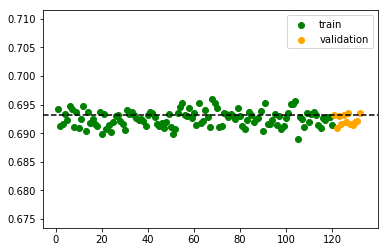

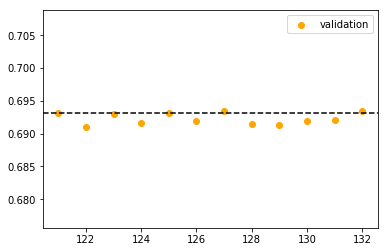

In [46]:
mn = 'ganmore'
plt.figure(0)
plt.scatter(ll_list[0][mn].eras,ll_list[0][mn].log_loss,label='train',color='green')
plt.scatter(ll_list[1][mn].eras,ll_list[1][mn].log_loss,label='validation',color='orange')
plt.legend()
plt.axhline(y=-np.log(0.5), xmin=0, xmax=1,color='k',linestyle='--')
plt.figure(1)
plt.scatter(ll_list[1][mn].eras,ll_list[1][mn].log_loss,label='validation',color='orange')
plt.legend()
plt.axhline(y=-np.log(0.5), xmin=0, xmax=1,color='k',linestyle='--')

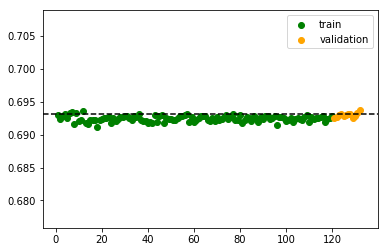

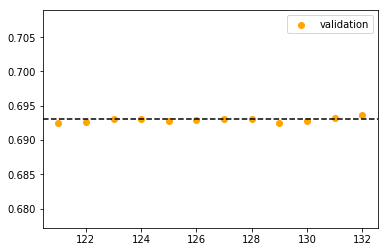

In [12]:
mn = 'aecganxg'
plt.figure(0)
plt.scatter(ll_list[0][mn].eras,ll_list[0][mn].log_loss,label='train',color='green')
plt.scatter(ll_list[1][mn].eras,ll_list[1][mn].log_loss,label='validation',color='orange')
plt.legend()
plt.axhline(y=-np.log(0.5), xmin=0, xmax=1,color='k',linestyle='--')
plt.figure(1)
plt.scatter(ll_list[1][mn].eras,ll_list[1][mn].log_loss,label='validation',color='orange')
plt.legend()
plt.axhline(y=-np.log(0.5), xmin=0, xmax=1,color='k',linestyle='--')

In [29]:
import numpy as np
import pandas as pd
from sklearn.decomposition import FastICA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator

#X_test,y_test,ids,_eras,_datatypes=get_data(data_files[-1]['testpath'])
#X_train,y_train,X_val,y_val = get_data_era_balanced(data_files[-1]['trainpath'])

# Score on the training set was:0.6049871246781169
# exported_pipeline = make_pipeline(
#     FastICA(tol=0.35000000000000003),
#     StackingEstimator(estimator=ExtraTreesClassifier(bootstrap=False, criterion="gini", max_features=0.1, min_samples_leaf=3, min_samples_split=14, n_estimators=100)),
#     ExtraTreesClassifier(bootstrap=False, criterion="entropy", max_features=0.6500000000000001, min_samples_leaf=17, min_samples_split=13, n_estimators=100)
# )
args = [
    FastICA(tol=0.35000000000000003),
    StackingEstimator(estimator=ExtraTreesClassifier(bootstrap=False, criterion="gini", max_features=0.1, min_samples_leaf=3, min_samples_split=7, n_estimators=100)),
    ExtraTreesClassifier(bootstrap=False, criterion="entropy", max_features=0.6500000000000001, min_samples_leaf=, min_samples_split=6, n_estimators=80),

]
exported_pipeline = make_pipeline(
    *args,
    memory=memory
)

exported_pipeline.fit(X_train, y_train)
results = exported_pipeline.predict(X_test)


import pickle
with open('mymodel','wb') as f:
    pickle.dump(model,f)

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(FastICA(algorithm='parallel', fun='logcosh', fun_args=None, max_iter=200,
    n_components=None, random_state=None, tol=0.35000000000000003,
    w_init=None, whiten=True), 
None, array([[ 0.32541, ...,  0.50667],
       ..., 
       [ 0.43276, ...,  0.54182]]), 
array([ 0., ...,  1.]))
_______________________________________________fit_transform_one - 12.4s, 0.2min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(StackingEstimator(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=0.1, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=7,
           min_weight_fraction_leaf=

In [32]:
for p in ['trainpath','testpath']:
    X__,y__,ids__,eras__,datatypes__=get_data(data_files[-1][p])
    results = exported_pipeline.predict_proba(X__)
    val_eras = [x for x in np.unique(eras__) if x not in ['eraX']]
    ll = {}
    name = 'tpot'
    ll[name]=[]
    for era in val_eras:
        inds = np.array(np.where(eras__==era)).squeeze()
        l = opt.log_loss_func([1.],[results[inds]],y__[inds])
        ll[name].append({'eras':to_int(era),'log_loss':l})
    ll[name] = pd.DataFrame(ll[name])
    ll_list.append(ll)
    for k in sorted(ll.keys()):
        v = ll[k].log_loss
        consistency = np.sum(v<-np.log(0.5))/len(v)
        mila = np.mean(v)
        print('{} {} cons:{:1.4f} logloss:{:1.4f}'.format(p,k,consistency,mila))


trainpath tpot cons:1.0000 logloss:0.1618
testpath tpot cons:0.0000 logloss:1.5707


In [ ]:
opt_weights = opt.opt_weights(y_pred_list,y_test[val_inds])

In [ ]:
opt_pred = opt.opt_pred(y_pred_list,opt_weights)
print(len(y_pred_list),opt_weights.shape,opt_pred.shape)
print('final logloss',name,opt.log_loss_func([1.0],[opt_pred],y_test[val_inds]))

In [ ]:
print(['{:.8f}'.format(x) for x in opt_weights])
print(np.sum(opt_weights))